In [1]:
import numpy as np
from numpy import linalg as la
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import cvxpy as cp
import random
import time
import os
from joblib import Parallel, delayed

from src.model import Nonneg_dagma, MetMulDagma, MetMulColide
import src.utils as utils

SEED = 0 #10
N_CPUS = os.cpu_count()

PATH_SACHS = './datasets/sachs/'
DATASET = "SYNTH"  # SYNTH, SACHS

np.random.seed(SEED)
random.seed(SEED)

In [2]:
def get_lamb_value(n_nodes, n_samples, times=1):
    return np.sqrt(np.log(n_nodes) / n_samples) * times 

def compute_errsW(W_seq, A):
    errs = np.zeros(len(W_seq))
    norm_A = la.norm(A)
    for i, W_est in enumerate(W_seq):
        errs[i] = (la.norm(A - W_est)/norm_A)**2
    
    return errs

def plot_result_Sigma(Sig_true, Sig_est, plot_matrices=True):
    fro_err = utils.compute_norm_sq_err(Sig_true, Sig_est)
        
    print(f'Err: {fro_err:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(1,2,1)
        plt.imshow(np.diag(Sig_true))
        plt.colorbar()
        plt.title("Sigma true")
        plt.subplot(1,2,2)
        plt.imshow(np.diag(Sig_est))
        plt.colorbar()
        plt.title("Sigma est")

def plot_result(A_true, A_est, thr, plot_matrices=True):
    A_est_bin = utils.to_bin(A_est, thr)
    A_true_bin = utils.to_bin(A_true, thr)

    fro_err = utils.compute_norm_sq_err(A_true, A_est)
    fro_err_bin = utils.compute_norm_sq_err(A_true_bin, A_est_bin)
    sdh, _, _ = utils.count_accuracy(A_true_bin, A_est_bin)
    fscore = f1_score(A_true_bin.flatten(), A_est_bin.flatten())

    print(f'Err: {fro_err:.3f}  -  Err bin: {fro_err_bin:.3f}  -  shd: {sdh}  -  fscore: {fscore:.3f}')

    if plot_matrices:
        plt.figure(figsize=(8, 8))
        plt.subplot(2,2,1)
        plt.imshow(A_true)
        plt.colorbar()
        plt.title("A true")
        plt.subplot(2,2,2)
        plt.imshow(A_est)
        plt.colorbar()
        plt.title("A est")
        plt.subplot(2,2,3)
        plt.imshow(A_true_bin)
        plt.colorbar()
        plt.title("A true bin")
        plt.subplot(2,2,4)
        plt.imshow(A_est_bin)
        plt.colorbar()
        plt.title("A est bin")

def plot_convergence(model, var_true, var_name='W'):
    if var_name == 'Sigma':
        var_seq = model.seq_Sig
        var_diff = model.diff_Sig
    else:
        var_seq = model.seq_W
        var_diff = model.diff_W

    errs_var = compute_errsW(var_seq, var_true)

    plt.figure(figsize=(12, 4))
    plt.subplot(1,3,1)
    plt.semilogy(var_diff)
    plt.grid(True)
    plt.title(f'Convergence of {var_name}')
    plt.subplot(1,3,2)
    plt.semilogy(errs_var)
    plt.grid(True)
    plt.title(f'Error of {var_name}')
    plt.subplot(1,3,3)
    plt.semilogy(model.acyclicity)
    plt.grid(True)
    plt.title('Acyclicity')
    plt.tight_layout()

# Generate data

In [3]:
# DAG parameters
N = 20
g_type = 'er'
edges = N*4
edge_type = 'positive'  # Options: binary, positive, weighted
w_range = (.5, 1)  #(.3, .9)
norm_x = False
M = 5000 # 1000 #500
variance = 1 # 1/np.sqrt(N)
Sigma = np.sqrt(variance)*np.ones(N)

if DATASET == "SACHS":
    A = np.load(PATH_SACHS + "sachs_A_matrix.npy")
    X = np.load(PATH_SACHS + "sachs_X.npy")
    M, N = X.shape
else:
    A, _, X = utils.simulate_sem(N, M, g_type, edges, permute=False, edge_type=edge_type,
                                w_range=w_range, noise_type='normal', var=variance)

if norm_x:
    X = X/la.norm(X, axis=1, keepdims=True)

print(f'Mean degree: {(A.sum(axis=0).mean()):2f}')
print('Mean norm of X:', la.norm(X, axis=1).mean())
print('Fidelity error:', 1/M*la.norm(X - X @ A, 'fro')**2)



Mean degree: 2.826427
Mean norm of X: 95.08157724076888
Fidelity error: 19.894997745171796


5343


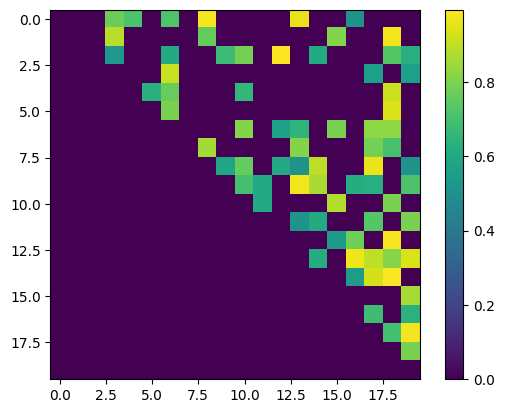

In [4]:
plt.imshow(A)
plt.colorbar()

cont = 0
for i in range(10000):
    x = np.random.randn(N,1)
    # suma = x.T @ (np.eye(N) + A) @ x
    suma = x.T @ (A) @ x
    cont += 1 if suma < -1e-6 else 0

print(cont)

# Algorithms with LogDet Acyclicity

## Projected Gradient Descents Algorithms

### PGD

lamb: 0.0024477468306808164


Accelerated: Solved in 26.213462 seconds
Mean est value: 0.1325618131775091
Err: 0.060  -  Err bin: 0.101  -  shd: 7  -  fscore: 0.949


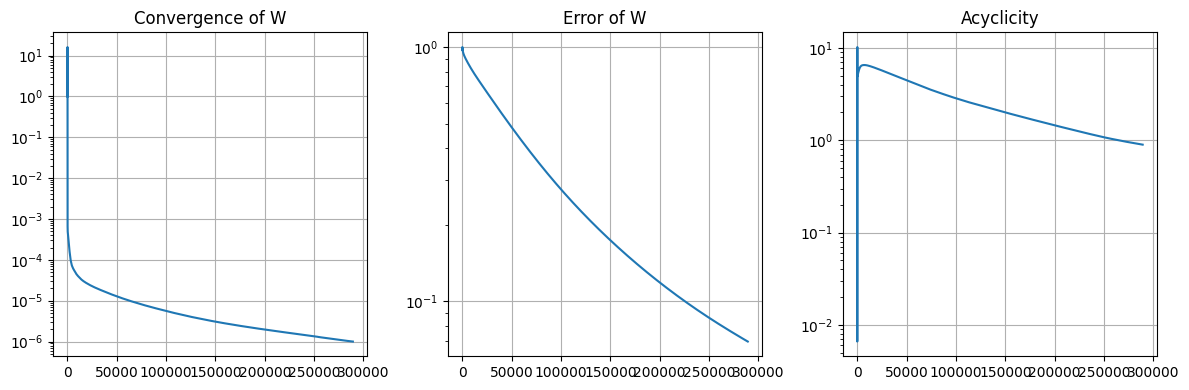

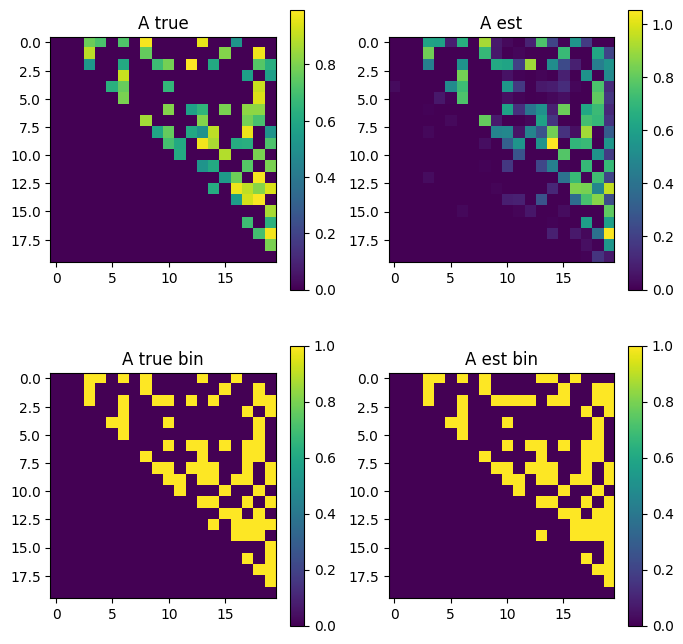

In [5]:
lamb = get_lamb_value(N, M, 1e-1)
print('lamb:', lamb)
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# Normalized
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 1000000, 'tol': 1e-6}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='pgd', restart=False)
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

lamb: 0.0024477468306808164
Accelerated: Solved in 16.280163 seconds
Mean est value: 0.1417996116877015
Err: 0.090  -  Err bin: 0.119  -  shd: 7  -  fscore: 0.940


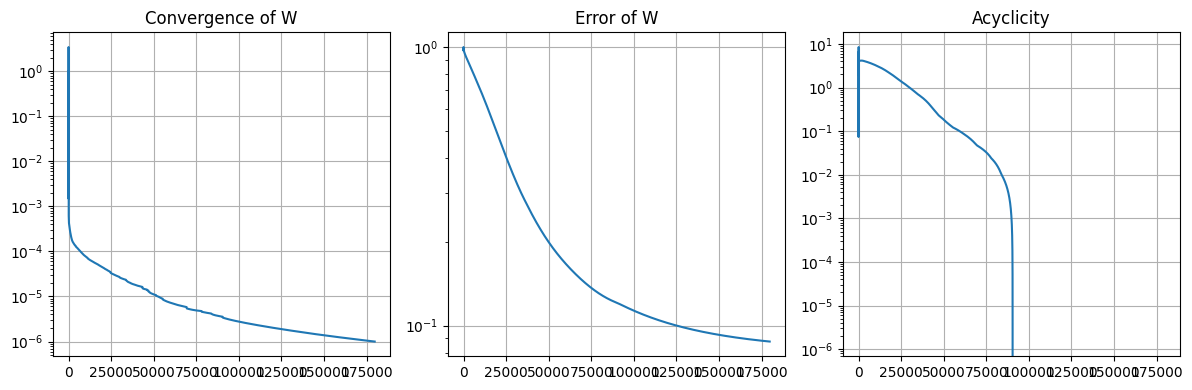

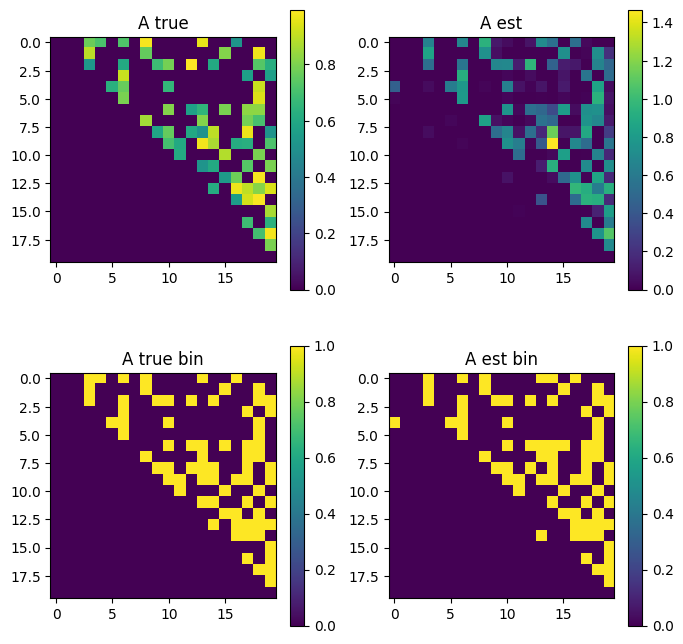

In [7]:
lamb = get_lamb_value(N, M, 1e-1)
print('lamb:', lamb)
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# Normalized
args = {'stepsize': 5e-3, 'alpha': 2, 's': 1, 'lamb': lamb, 'max_iters': 1000000, 'tol': 1e-6}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='pgd', restart=False)
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

lamb: 0.0024477468306808164
Accelerated: Solved in 16.272061 seconds
Mean est value: 0.1443260961711247
Err: 0.089  -  Err bin: 0.131  -  shd: 8  -  fscore: 0.934


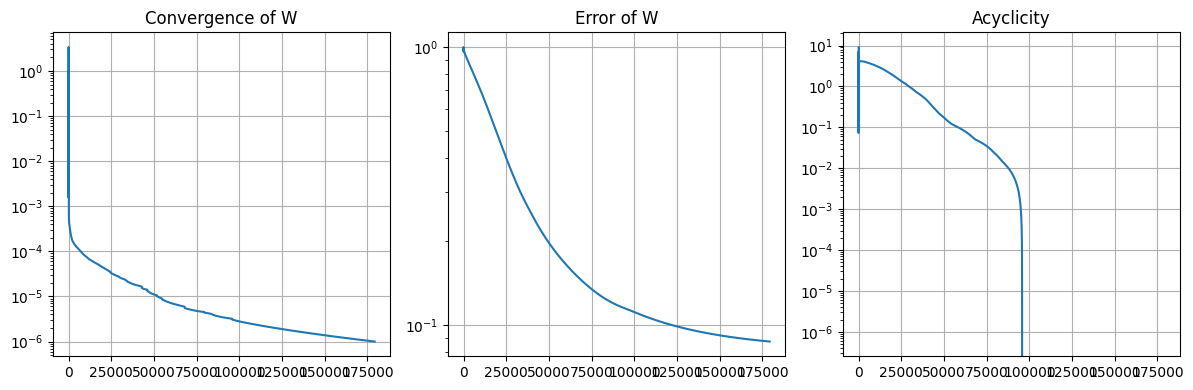

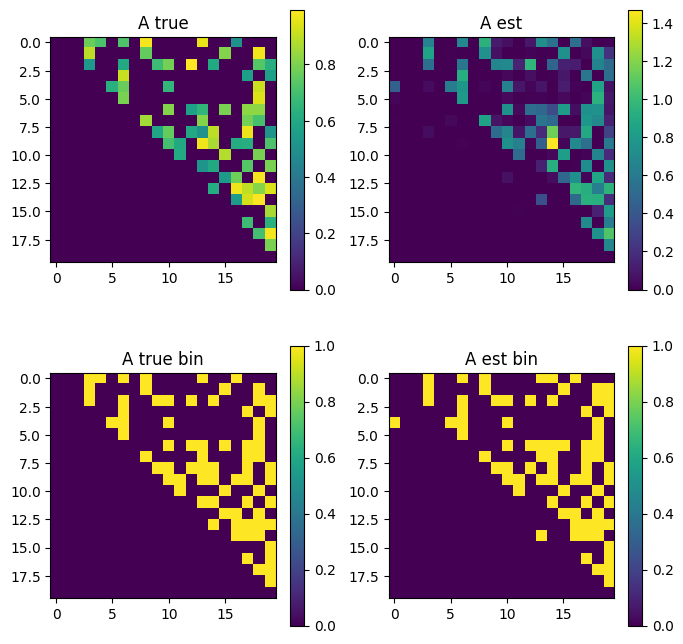

In [ ]:
lamb = get_lamb_value(N, M, 1e-1)
print('lamb:', lamb)
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# Normalized
args = {'stepsize': 5e-3, 'alpha': 2, 's': 1, 'lamb': 5*lamb, 'max_iters': 1000000, 'tol': 1e-6}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='pgd', restart=False)
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### FISTA

Accelerated: Solved in 0.341187 seconds
Mean est value: 0.1403126694145768
Err: 0.002  -  Err bin: 0.000  -  shd: 0  -  fscore: 1.000


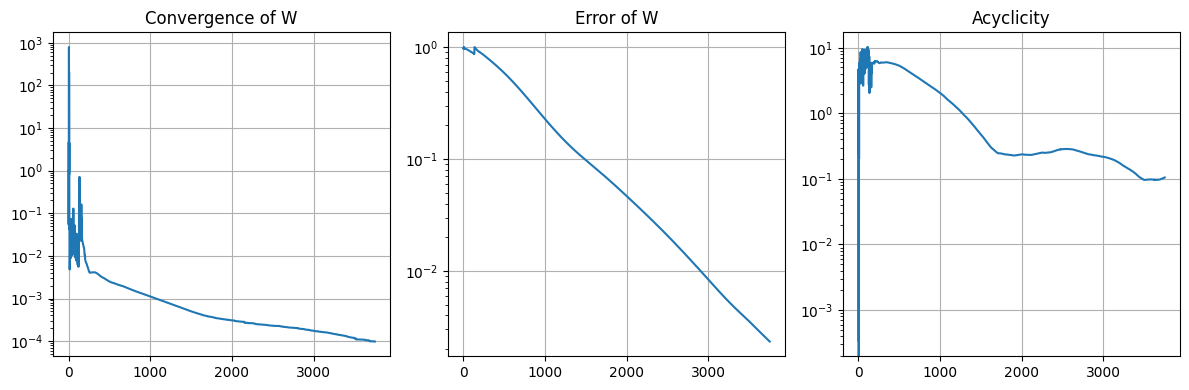

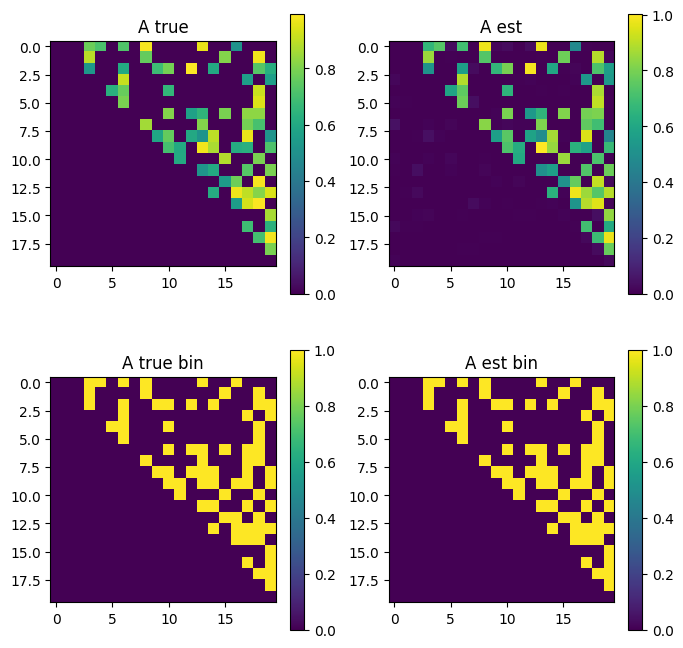

In [7]:
lamb = get_lamb_value(N, M, 1e-1)
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# Normalized
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='fista', restart=False)
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

Accelerated: Solved in 0.170875 seconds
Mean est value: 0.14109936763483388
Err: 0.109  -  Err bin: 0.207  -  shd: 16  -  fscore: 0.894


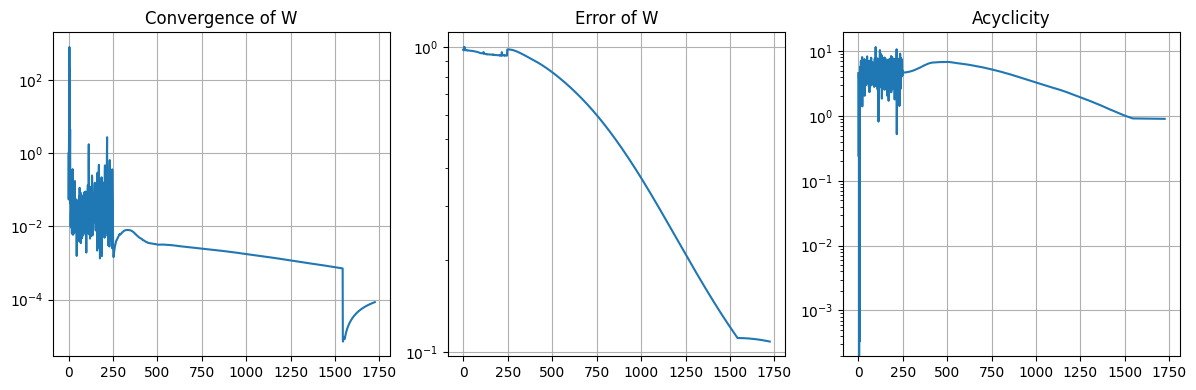

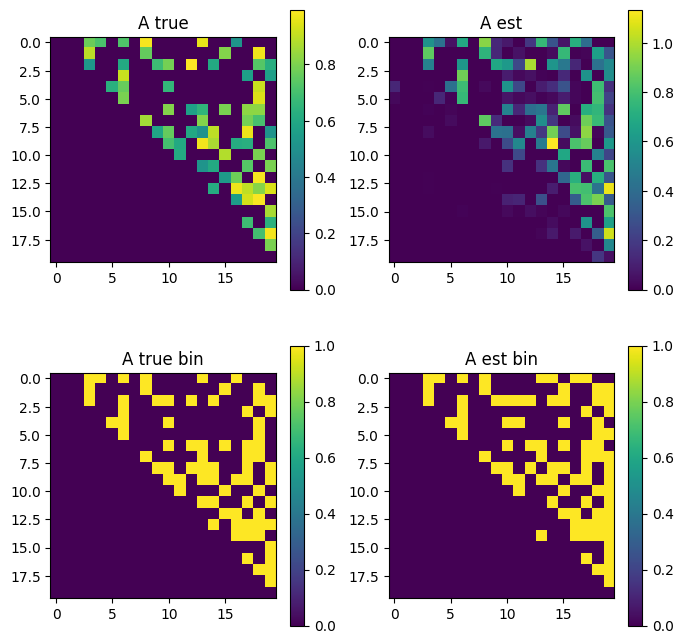

In [8]:
lamb = get_lamb_value(N, M, 1e-1)
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# Normalized
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='fista', restart=True)
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Proj Adam

Adam: Solved in 1.540122 seconds
Mean est value: 0.13984474779863237
Err: 0.001  -  Err bin: 0.000  -  shd: 0  -  fscore: 1.000


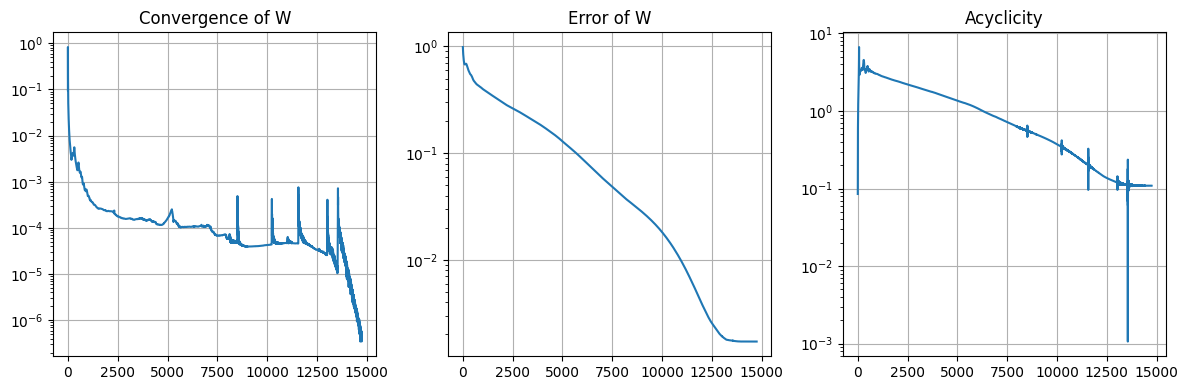

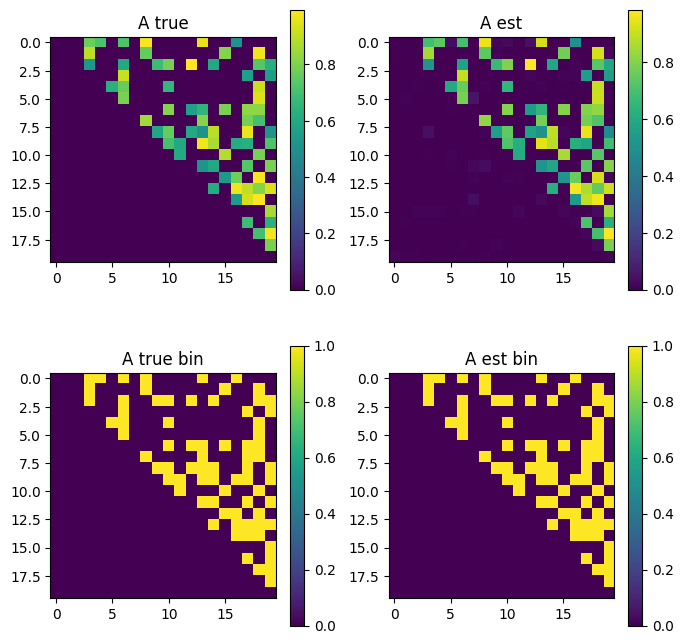

In [9]:
lamb = get_lamb_value(N, M,1e-1)
args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-6}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='logdet', primal_opt='adam')
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Adam: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

## Method of Multipliers Algorithms

### Standard MM

lamb: 0.0024477468306808164
Negative acyclicity. Projecting and reducing stepsize to:  0.00015
Negative acyclicity. Projecting and reducing stepsize to:  7.5e-05
- 1/10. Diff: 0.000013 | Acycl: 6.899023 | Rho: 0.100 - Alpha: 0.700 - Step: 0.0001
- 2/10. Diff: 0.000010 | Acycl: 1.648466 | Rho: 0.100 - Alpha: 0.865 - Step: 0.0001
- 3/10. Diff: 0.000005 | Acycl: 0.517782 | Rho: 0.200 - Alpha: 0.968 - Step: 0.0001
- 4/10. Diff: 0.000002 | Acycl: 0.175685 | Rho: 0.400 - Alpha: 1.039 - Step: 0.0001
- 5/10. Diff: 0.000002 | Acycl: 0.104278 | Rho: 0.800 - Alpha: 1.122 - Step: 0.0001
- 6/10. Diff: 0.000001 | Acycl: 0.042207 | Rho: 1.600 - Alpha: 1.190 - Step: 0.0001
- 7/10. Diff: 0.000001 | Acycl: 0.007887 | Rho: 1.600 - Alpha: 1.202 - Step: 0.0001
- 8/10. Diff: 0.000001 | Acycl: 0.000004 | Rho: 1.600 - Alpha: 1.202 - Step: 0.0001
- 9/10. Diff: 0.000001 | Acycl: 0.000004 | Rho: 3.200 - Alpha: 1.202 - Step: 0.0001
- 10/10. Diff: 0.000001 | Acycl: 0.000004 | Rho: 6.400 - Alpha: 1.202 - Step: 0.00

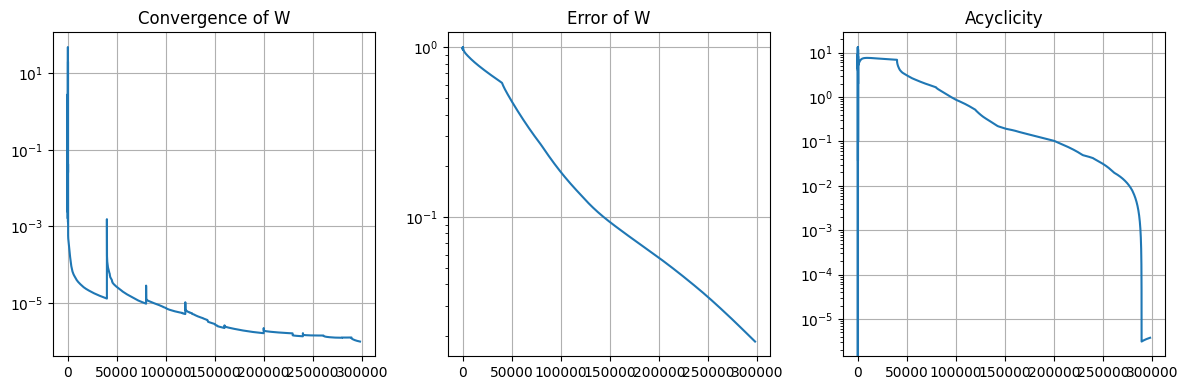

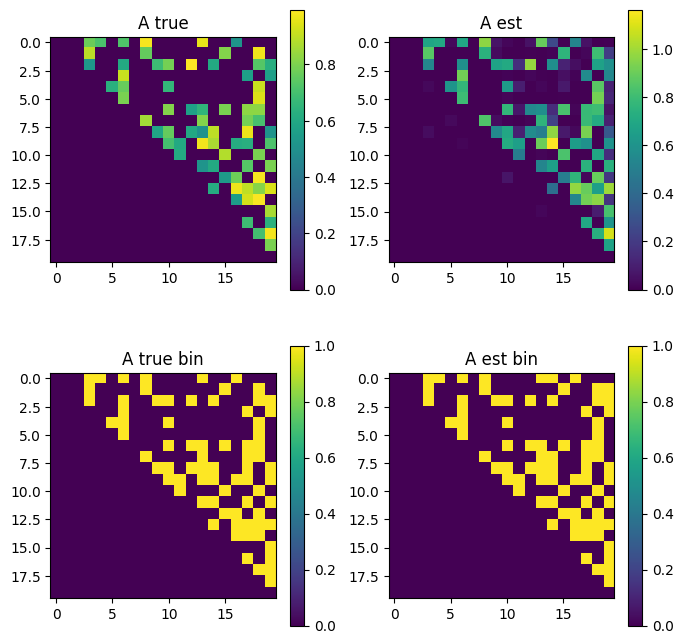

In [10]:
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 40000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}

# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='logdet', primal_opt='pgd')
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

### MM + Fista

lamb: 0.006510494522874917
Negative acyclicity. Projecting and reducing stepsize to:  5e-06
Negative acyclicity. Projecting and reducing stepsize to:  2.5e-06
Negative acyclicity. Projecting and reducing stepsize to:  1.25e-06
Negative acyclicity. Projecting and reducing stepsize to:  6.25e-07
Negative acyclicity. Projecting and reducing stepsize to:  3.125e-07
- 1/50. Diff: 0.001278 | Acycl: 15.367574 | Rho: 0.015 - Alpha: 0.241 - Step: 0.0000
Negative acyclicity. Projecting and reducing stepsize to:  1.5625e-07
- 2/50. Diff: 0.000173 | Acycl: 34.673148 | Rho: 0.022 - Alpha: 1.021 - Step: 0.0000
- 3/50. Diff: 0.000089 | Acycl: 6.182727 | Rho: 0.022 - Alpha: 1.160 - Step: 0.0000
- 4/50. Diff: 0.000048 | Acycl: 1.578270 | Rho: 0.034 - Alpha: 1.213 - Step: 0.0000
- 5/50. Diff: 0.000001 | Acycl: 1.563238 | Rho: 0.051 - Alpha: 1.292 - Step: 0.0000
Negative acyclicity. Projecting and reducing stepsize to:  7.8125e-08
- 6/50. Diff: 0.000000 | Acycl: 0.000025 | Rho: 0.051 - Alpha: 1.292 - Ste

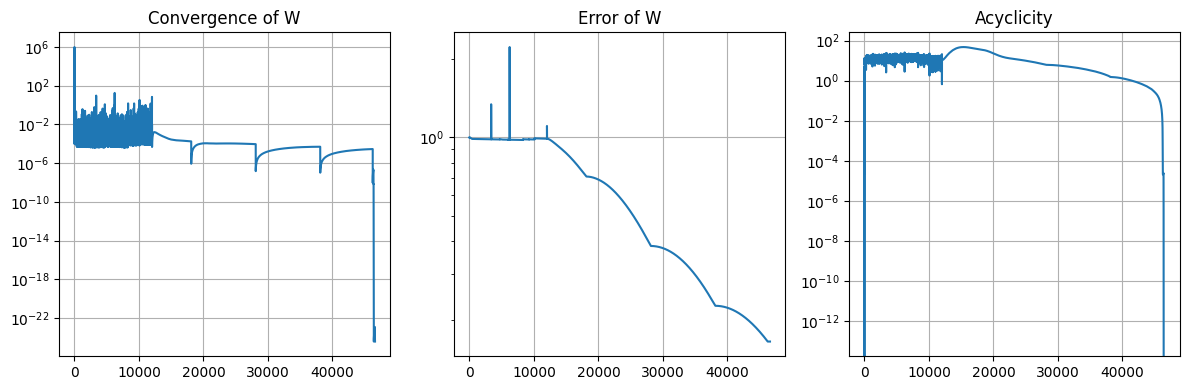

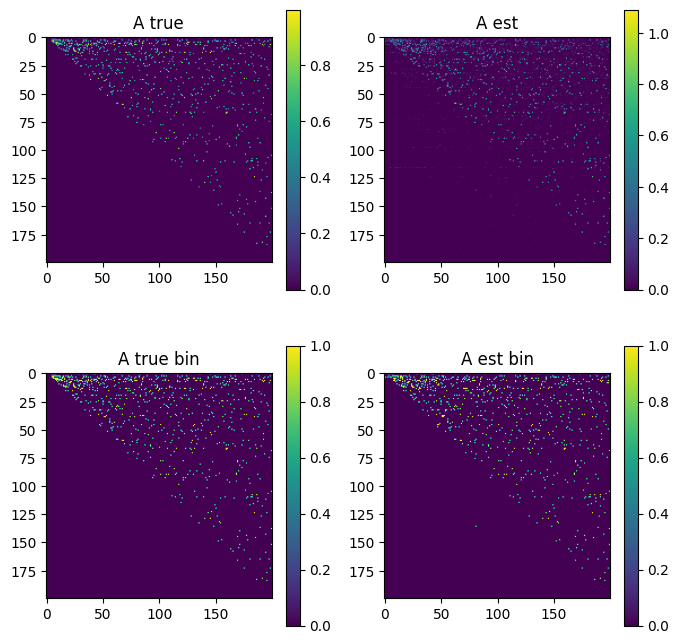

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 2e-1)
# ER
# args = {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}
args = {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 10000,
            'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='logdet', primal_opt='fista', restart=True)
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

lamb: 0.006510494522874917
Negative acyclicity. Projecting and reducing stepsize to:  3.5e-06
Negative acyclicity. Projecting and reducing stepsize to:  1.75e-06
Negative acyclicity. Projecting and reducing stepsize to:  8.75e-07
Negative acyclicity. Projecting and reducing stepsize to:  4.375e-07
Negative acyclicity. Projecting and reducing stepsize to:  2.1875e-07
- 1/50. Diff: 0.000083 | Acycl: 41.107138 | Rho: 0.015 - Alpha: 0.627 - Step: 0.0000
- 2/50. Diff: 0.000040 | Acycl: 2.690471 | Rho: 0.015 - Alpha: 0.667 - Step: 0.0000
- 3/50. Diff: 0.000001 | Acycl: 2.658428 | Rho: 0.022 - Alpha: 0.727 - Step: 0.0000
- 4/50. Diff: 0.000001 | Acycl: 2.599486 | Rho: 0.034 - Alpha: 0.815 - Step: 0.0000
Negative acyclicity. Projecting and reducing stepsize to:  1.09375e-07
- 5/50. Diff: 0.000000 | Acycl: 0.000153 | Rho: 0.034 - Alpha: 0.815 - Step: 0.0000
- 6/50. Diff: 0.000000 | Acycl: 0.000153 | Rho: 0.051 - Alpha: 0.815 - Step: 0.0000
- 7/50. Diff: 0.000000 | Acycl: 0.000153 | Rho: 0.076 -

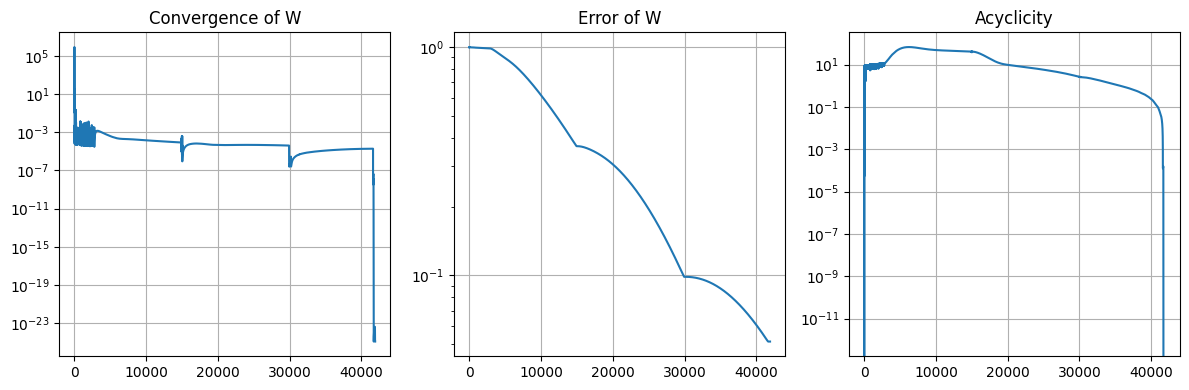

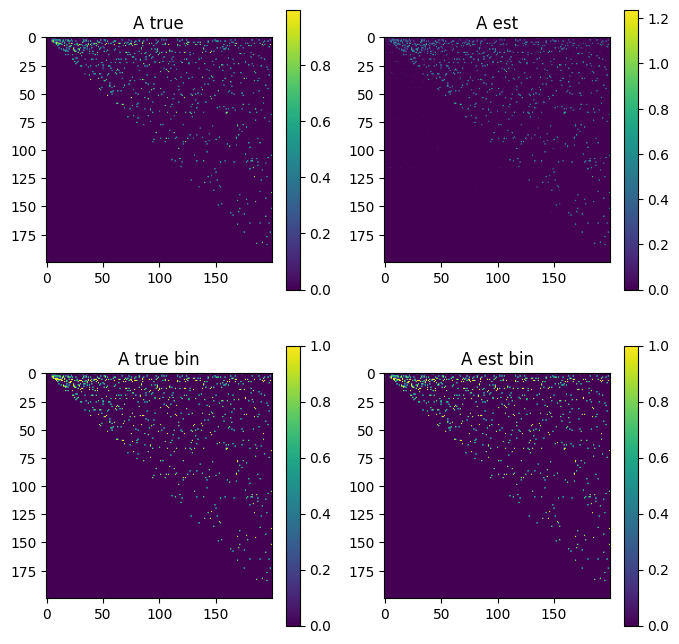

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 2e-1)
# ER
# args = {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}
args = {'stepsize': 7e-6, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 15000,
            'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='logdet', primal_opt='fista', restart=True)
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

lamb: 0.006510494522874917
Negative acyclicity. Projecting and reducing stepsize to:  5e-06
Negative acyclicity. Projecting and reducing stepsize to:  2.5e-06
Negative acyclicity. Projecting and reducing stepsize to:  1.25e-06
Negative acyclicity. Projecting and reducing stepsize to:  6.25e-07
Negative acyclicity. Projecting and reducing stepsize to:  3.125e-07
- 1/50. Diff: 0.000324 | Acycl: 15.722132 | Rho: 0.015 - Alpha: 0.246 - Step: 0.0000
- 2/50. Diff: 0.000129 | Acycl: 19.625542 | Rho: 0.022 - Alpha: 0.687 - Step: 0.0000
- 3/50. Diff: 0.000517 | Acycl: 12.097395 | Rho: 0.034 - Alpha: 1.096 - Step: 0.0000
Negative acyclicity. Projecting and reducing stepsize to:  1.5625e-07
- 4/50. Diff: 0.000175 | Acycl: 12.074009 | Rho: 0.051 - Alpha: 1.707 - Step: 0.0000
- 5/50. Diff: 0.000057 | Acycl: 0.296585 | Rho: 0.051 - Alpha: 1.722 - Step: 0.0000
- 6/50. Diff: 0.000000 | Acycl: 0.296584 | Rho: 0.076 - Alpha: 1.744 - Step: 0.0000
- 7/50. Diff: 0.000000 | Acycl: 0.296584 | Rho: 0.114 - Al

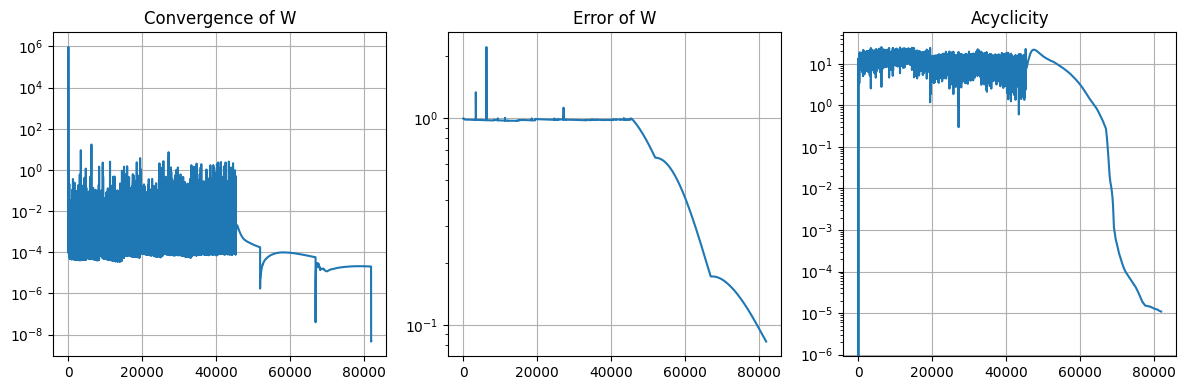

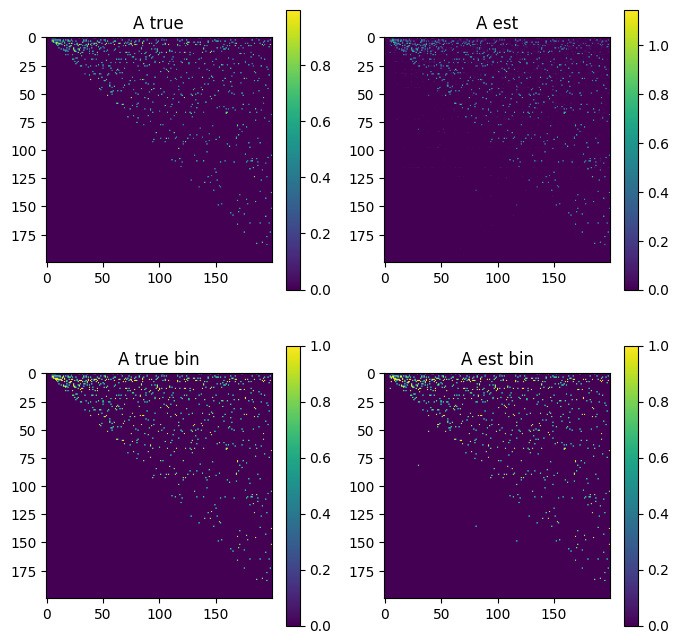

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 2e-1)
# ER
# args = {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}
args = {'stepsize': 1e-5, 'alpha_0': .01, 'rho_0': .01, 's': 1, 'lamb': lamb, 'iters_in': 15000,
            'iters_out': 50, 'tol': 1e-6, 'beta': 1.5, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='logdet', primal_opt='fista', restart=True)
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

### MM + Adam

lamb: 0.0032552472614374587
- 1/10. Diff: 0.000181 | Acycl: 15.357876 | Rho: 0.250 - Alpha: 3.849 - Step: 0.0003
- 2/10. Diff: 0.000084 | Acycl: 0.001686 | Rho: 0.250 - Alpha: 3.850 - Step: 0.0003
- 3/10. Diff: 0.000006 | Acycl: 0.000010 | Rho: 0.250 - Alpha: 3.850 - Step: 0.0003
- 4/10. Diff: 0.000003 | Acycl: 0.000010 | Rho: 1.250 - Alpha: 3.850 - Step: 0.0003
- 5/10. Diff: 0.000009 | Acycl: 0.000010 | Rho: 6.250 - Alpha: 3.850 - Step: 0.0003
- 6/10. Diff: 0.000001 | Acycl: 0.000010 | Rho: 31.250 - Alpha: 3.850 - Step: 0.0003
- 7/10. Diff: 0.000001 | Acycl: 0.000010 | Rho: 156.250 - Alpha: 3.852 - Step: 0.0003
- 8/10. Diff: 0.000000 | Acycl: 0.000010 | Rho: 781.250 - Alpha: 3.860 - Step: 0.0003
- 9/10. Diff: 0.000000 | Acycl: 0.000010 | Rho: 3906.250 - Alpha: 3.898 - Step: 0.0003
- 10/10. Diff: 0.000000 | Acycl: 0.000010 | Rho: 19531.250 - Alpha: 4.089 - Step: 0.0003
Solved in 421.268817 seconds
Mean est value: 0.014934060061862403
Err: 0.051  -  Err bin: 0.082  -  shd: 55  -  fscore

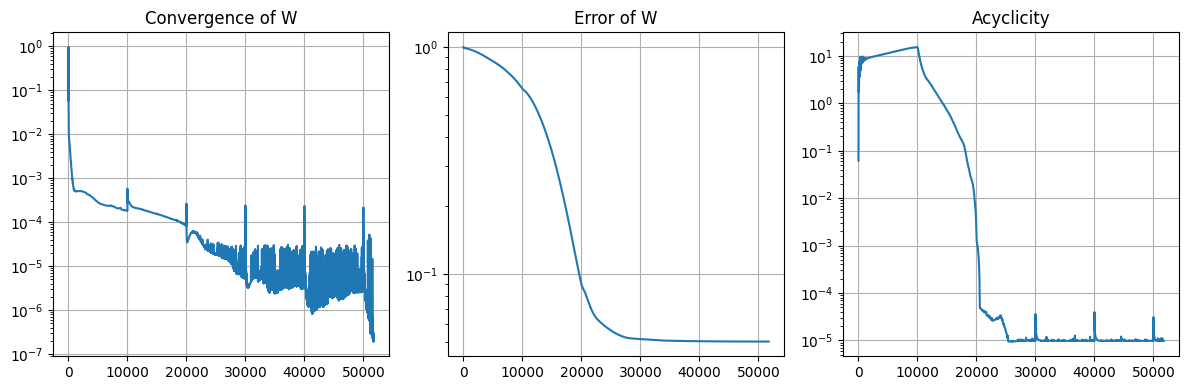

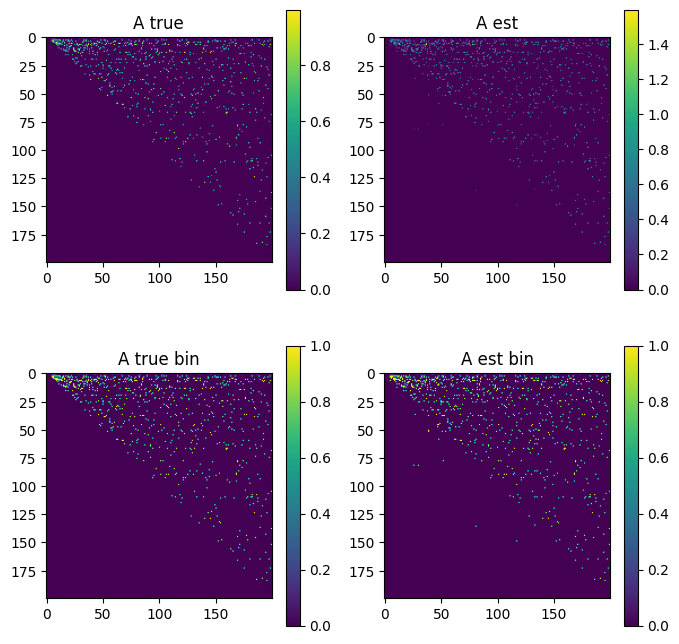

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 1e-1)
# ER
# args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 10000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}
# SF
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 10000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 5, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='logdet', primal_opt='adam')
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

## Cvx CoLiDE + Method of Multipliers Algorithms

### PGD

lamb: 0.006786140424415112
- 1/10. Diff W: 0.015600 | Diff Sigma: 0.000004 | Acycl: 7.361231 |Rho: 0.100 - Alpha: 0.746 - Step: 0.0003
- 2/10. Diff W: 0.012160 | Diff Sigma: 0.000004 | Acycl: 1.550200 |Rho: 0.100 - Alpha: 0.901 - Step: 0.0003
- 3/10. Diff W: 0.011550 | Diff Sigma: 0.000004 | Acycl: 1.218248 |Rho: 0.200 - Alpha: 1.145 - Step: 0.0003
- 4/10. Diff W: 0.011277 | Diff Sigma: 0.000005 | Acycl: 1.094794 |Rho: 0.400 - Alpha: 1.583 - Step: 0.0003
- 5/10. Diff W: 0.011032 | Diff Sigma: 0.000004 | Acycl: 0.956146 |Rho: 0.800 - Alpha: 2.348 - Step: 0.0003
- 6/10. Diff W: 0.010851 | Diff Sigma: 0.000009 | Acycl: 0.805624 |Rho: 1.600 - Alpha: 3.637 - Step: 0.0003
- 7/10. Diff W: 0.012230 | Diff Sigma: 0.000012 | Acycl: 0.655399 |Rho: 3.200 - Alpha: 5.734 - Step: 0.0003
- 8/10. Diff W: 0.011977 | Diff Sigma: 0.000008 | Acycl: 0.516097 |Rho: 6.400 - Alpha: 9.037 - Step: 0.0003
- 9/10. Diff W: 0.011728 | Diff Sigma: 0.000005 | Acycl: 0.389411 |Rho: 12.800 - Alpha: 14.021 - Step: 0.0003

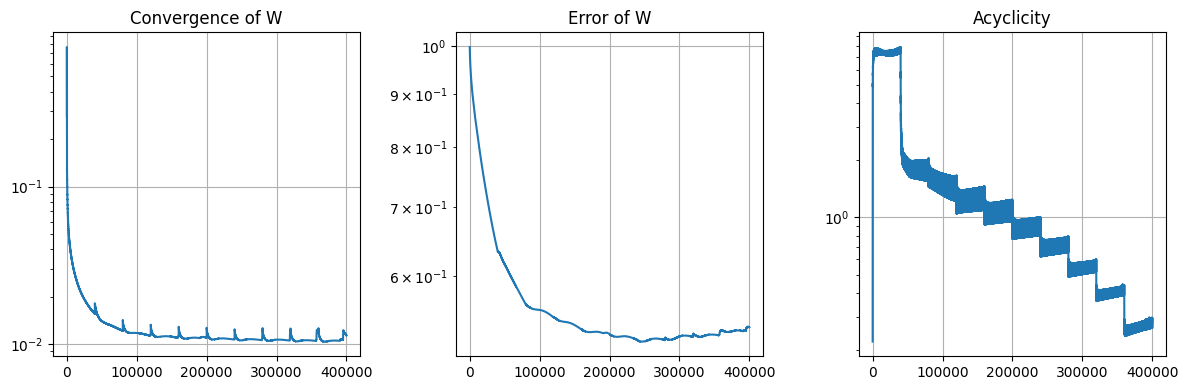

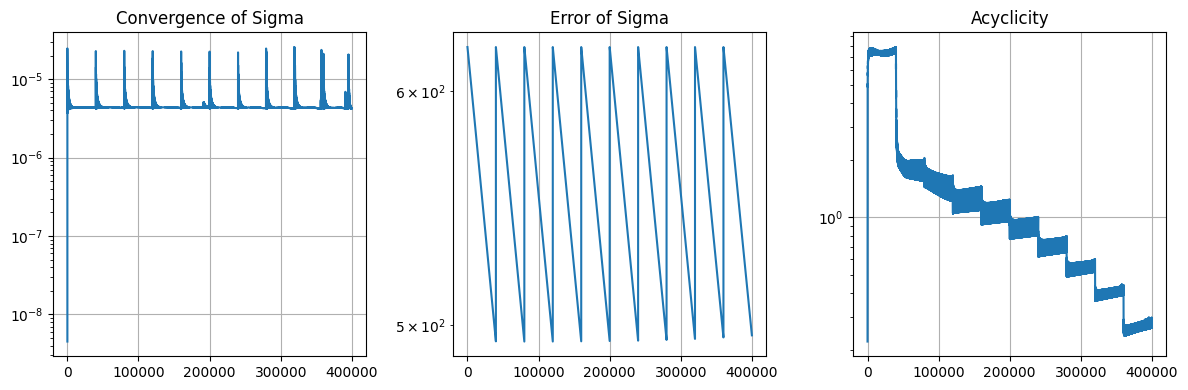

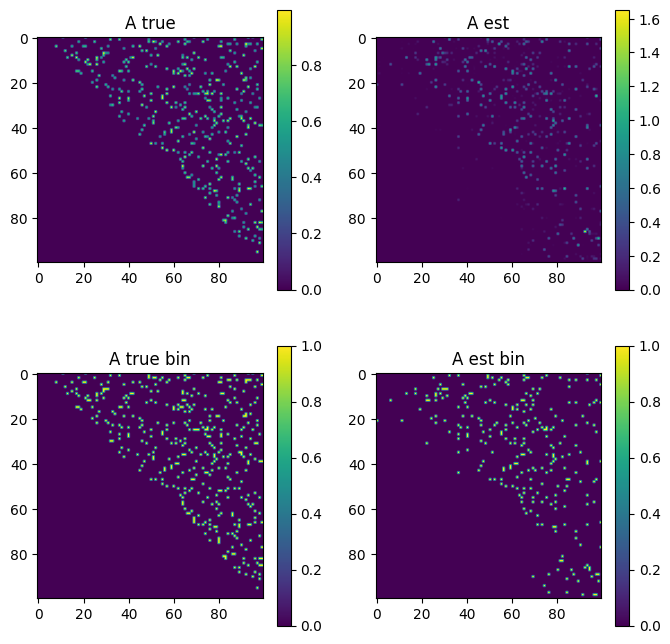

In [ ]:
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 40000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulColide(acyclicity='logdet', primal_opt='pgd', restart=False)
A_est, Sigma_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_convergence(model, Sigma, var_name="Sigma")
plot_result(A, A_est, thr)

### FISTA

lamb: 0.006786140424415112
Convergence achieved at iter 19251
- 1/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 9.113350 |Rho: 0.075 - Alpha: 0.694 - Step: 0.0001
Convergence achieved at iter 10751
- 2/10. Diff W: 0.000000 | Diff Sigma: 0.000000 | Acycl: 0.004412 |Rho: 0.075 - Alpha: 0.694 - Step: 0.0001
Convergence achieved at iter 9001
- 3/10. Diff W: 0.000000 | Diff Sigma: 0.000000 | Acycl: 0.004404 |Rho: 0.113 - Alpha: 0.694 - Step: 0.0001
Convergence achieved at iter 9001
- 4/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.004386 |Rho: 0.169 - Alpha: 0.695 - Step: 0.0001
Convergence achieved at iter 9001
- 5/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.004351 |Rho: 0.253 - Alpha: 0.696 - Step: 0.0001
Convergence achieved at iter 9001
- 6/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.004314 |Rho: 0.380 - Alpha: 0.698 - Step: 0.0001
Convergence achieved at iter 9001
- 7/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.004113 |Rho: 0.570 - Alpha

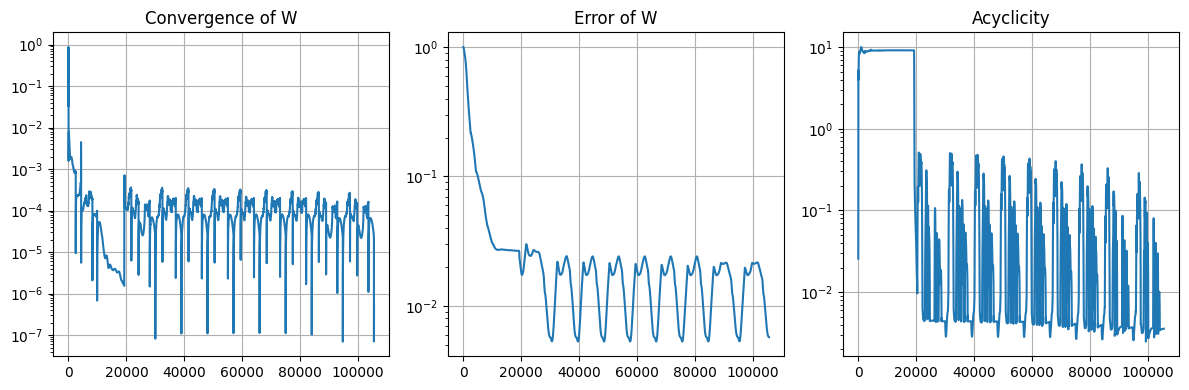

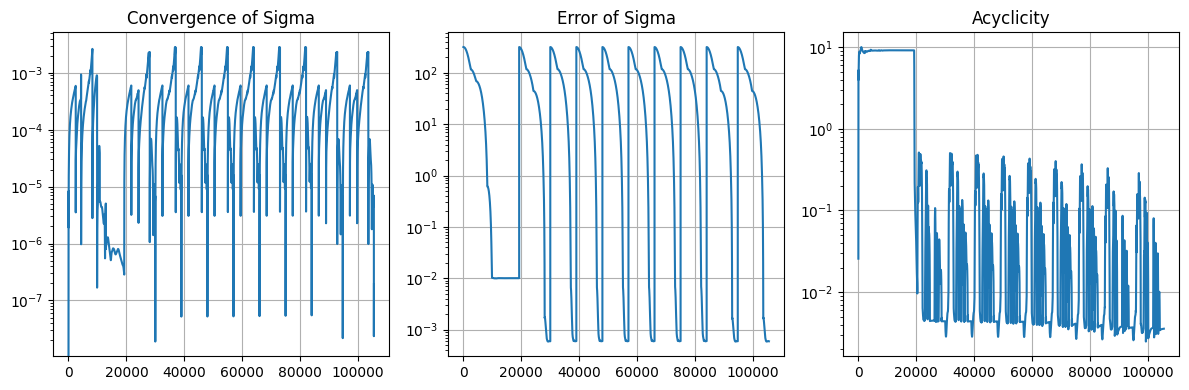

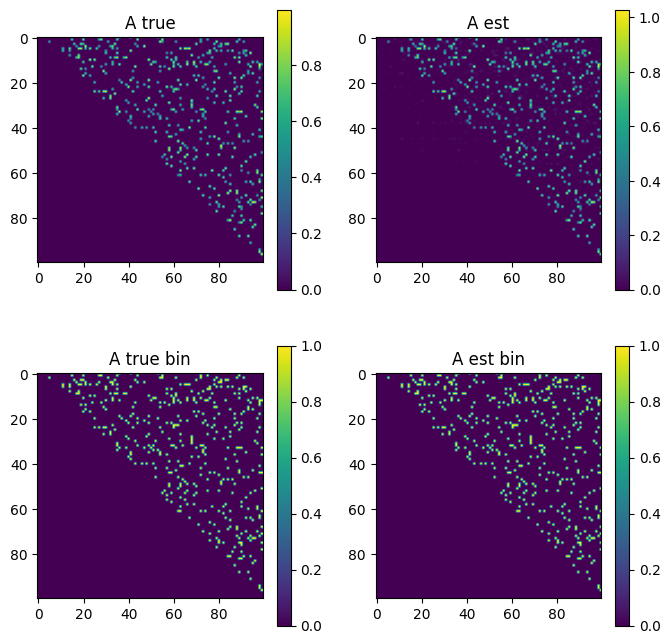

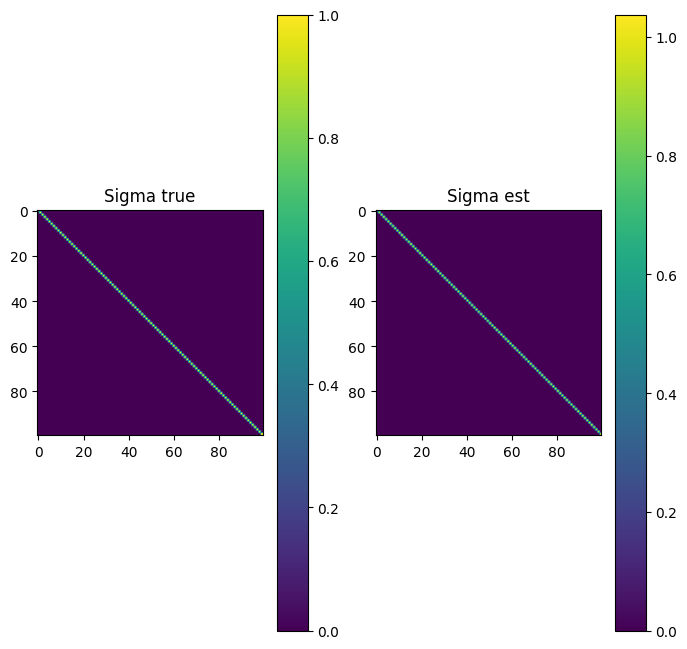

In [ ]:
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 5e-5, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
        'iters_out': 10, 'beta': 1.5, 'verb': True}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

print('lamb:', lamb)

t_i = time.time()
model = MetMulColide(acyclicity='logdet', primal_opt='fista', restart=True)
A_est, Sigma_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2   
plot_convergence(model, A, var_name="W")
plot_convergence(model, Sigma, var_name="Sigma")
plot_result(A, A_est, thr)
plot_result_Sigma(Sigma, Sigma_est)

### ADAM

lamb: 0.006786140424415112


- 1/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 8.718057 |Rho: 0.100 - Alpha: 0.882 - Step: 0.0003
- 2/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001384 |Rho: 0.100 - Alpha: 0.882 - Step: 0.0003
- 3/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001384 |Rho: 0.200 - Alpha: 0.882 - Step: 0.0003
- 4/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001382 |Rho: 0.400 - Alpha: 0.883 - Step: 0.0003
- 5/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001380 |Rho: 0.800 - Alpha: 0.884 - Step: 0.0003
- 6/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001374 |Rho: 1.600 - Alpha: 0.886 - Step: 0.0003
- 7/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001364 |Rho: 3.200 - Alpha: 0.890 - Step: 0.0003
- 8/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001343 |Rho: 6.400 - Alpha: 0.899 - Step: 0.0003
- 9/10. Diff W: 0.000006 | Diff Sigma: 0.000011 | Acycl: 0.001301 |Rho: 12.800 - Alpha: 0.916 - Step: 0.0003
- 10/10. Diff W: 0.000006 |

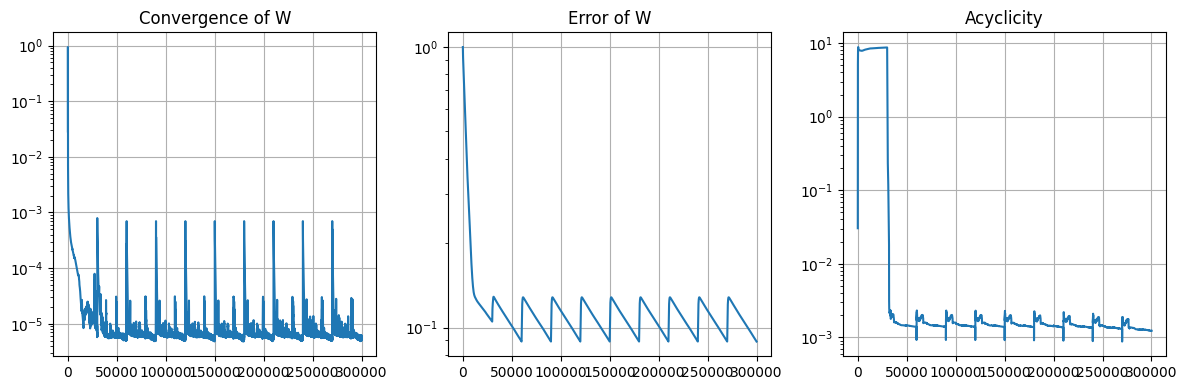

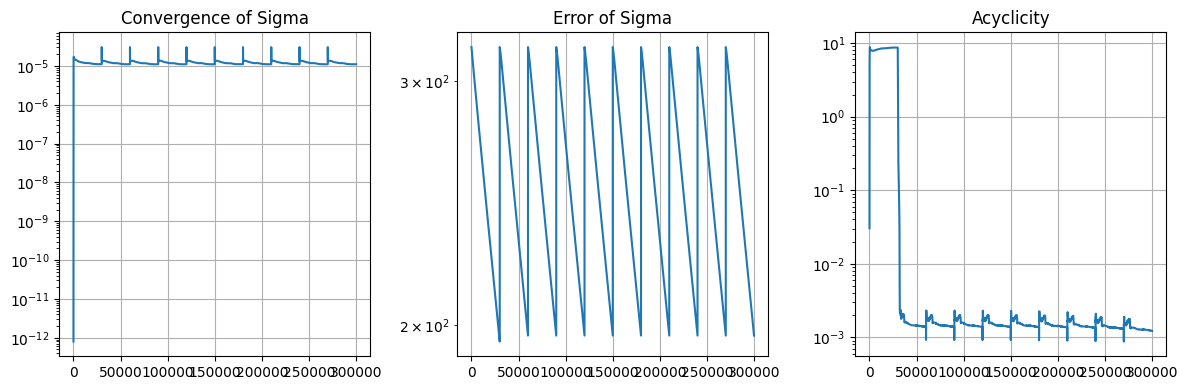

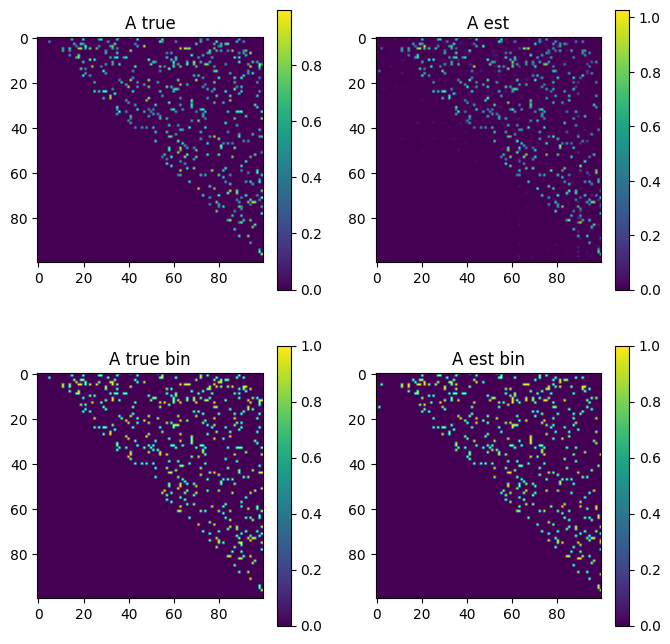

In [ ]:
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'verb': True}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

print('lamb:', lamb)

t_i = time.time()
model = MetMulColide(acyclicity='logdet', primal_opt='adam', restart=True)
A_est, Sigma_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model, A, var_name="W")
plot_convergence(model, Sigma, var_name="Sigma")
plot_result(A, A_est, thr)

### SCA

lamb: 0.06786140424415112


- 1/10. Diff W: 0.020781 | Diff Sigma: 0.240989 | Acycl: 1.996473 |Rho: 1.000 - Alpha: 2.496 - Step: 0.0003
Negative acyclicity. Projecting and reducing stepsize to:  0.00015
- 2/10. Diff W: 0.000012 | Diff Sigma: 0.000004 | Acycl: 0.074019 |Rho: 1.000 - Alpha: 2.570 - Step: 0.0001
- 3/10. Diff W: 0.000004 | Diff Sigma: 0.000001 | Acycl: 0.040498 |Rho: 2.000 - Alpha: 2.651 - Step: 0.0001
- 4/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.035436 |Rho: 4.000 - Alpha: 2.793 - Step: 0.0001
- 5/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.032382 |Rho: 8.000 - Alpha: 3.052 - Step: 0.0001
- 6/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.029601 |Rho: 16.000 - Alpha: 3.526 - Step: 0.0001
- 7/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.023819 |Rho: 32.000 - Alpha: 4.288 - Step: 0.0001
- 8/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.017787 |Rho: 64.000 - Alpha: 5.426 - Step: 0.0001
- 9/10. Diff W: 0.000002 | Diff Sigma: 0.000000 | Acycl: 0.011107 

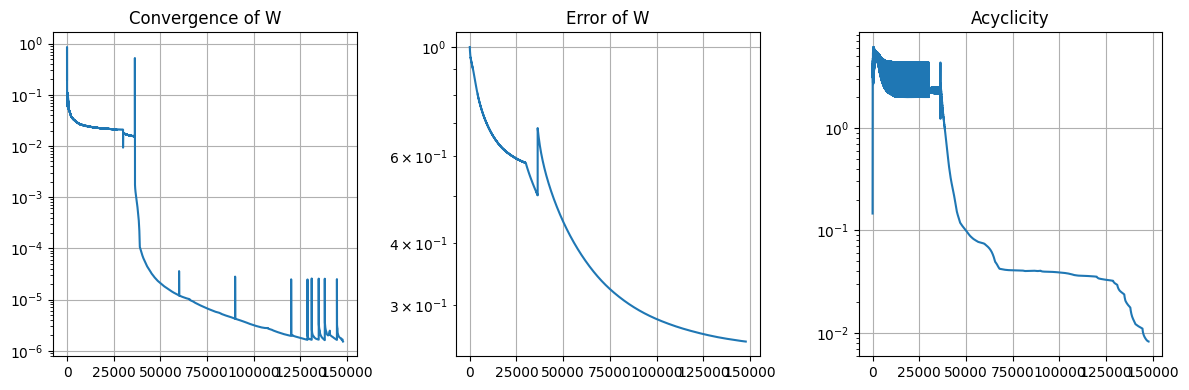

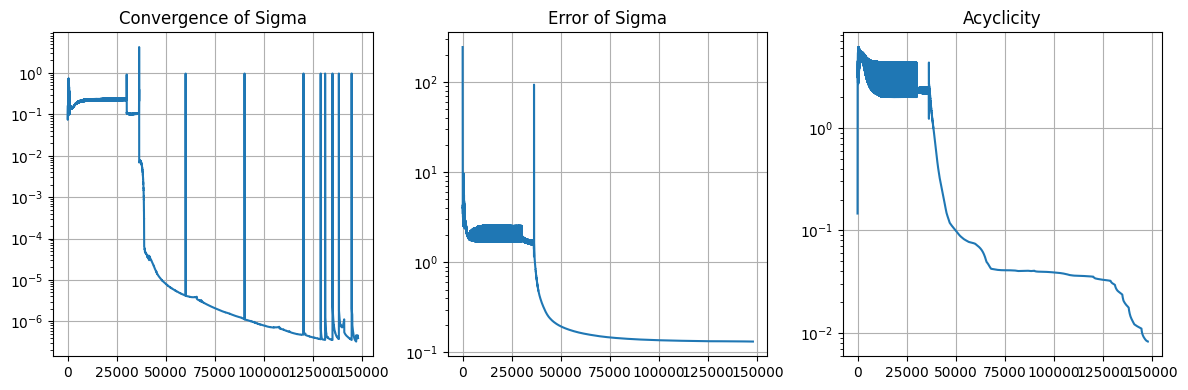

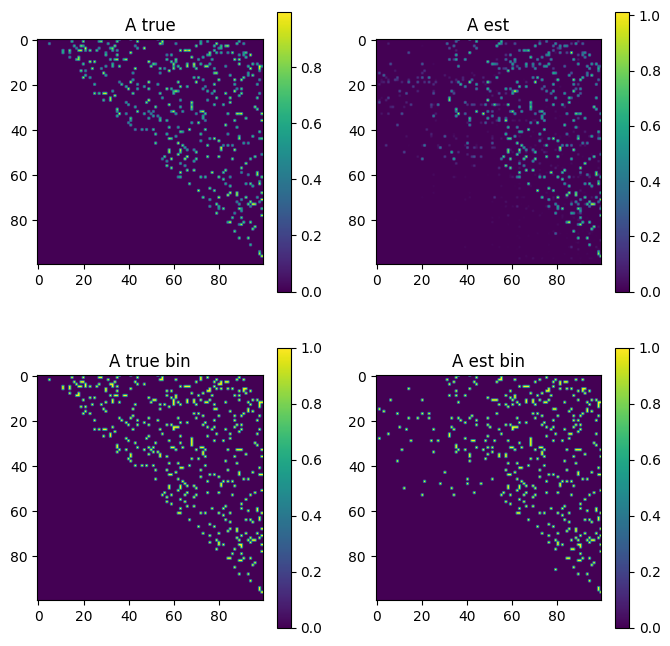

In [ ]:
lamb = get_lamb_value(N, M, 1)
args = {'stepsize': 3e-4, 'alpha_0': .5, 'rho_0': .5, 's': 1, 'lamb': lamb, 'iters_in': 30000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'sca_adam': False, 'verb': True}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

print('lamb:', lamb)

t_i = time.time()
model = MetMulColide(acyclicity='logdet', primal_opt='sca', restart=True)
A_est, Sigma_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model, A, var_name="W")
plot_convergence(model, Sigma, var_name="Sigma")
plot_result(A, A_est, thr)

lamb: 0.006786140424415112
- 1/10. Diff W: 0.000001 | Diff Sigma: 0.000001 | Acycl: 9.110301 |Rho: 0.100 - Alpha: 0.921 - Step: 0.0003
Negative acyclicity. Projecting and reducing stepsize to:  0.00015
- 2/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000938 |Rho: 0.100 - Alpha: 0.921 - Step: 0.0001
- 3/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000938 |Rho: 0.200 - Alpha: 0.921 - Step: 0.0001
- 4/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000938 |Rho: 0.400 - Alpha: 0.922 - Step: 0.0001
- 5/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000937 |Rho: 0.800 - Alpha: 0.922 - Step: 0.0001
- 6/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000936 |Rho: 1.600 - Alpha: 0.924 - Step: 0.0001
- 7/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000932 |Rho: 3.200 - Alpha: 0.927 - Step: 0.0001
- 8/10. Diff W: 0.000001 | Diff Sigma: 0.000000 | Acycl: 0.000927 |Rho: 6.400 - Alpha: 0.933 - Step: 0.0001
- 9/10. Diff W: 0.000001 | Diff Sigma: 0.0

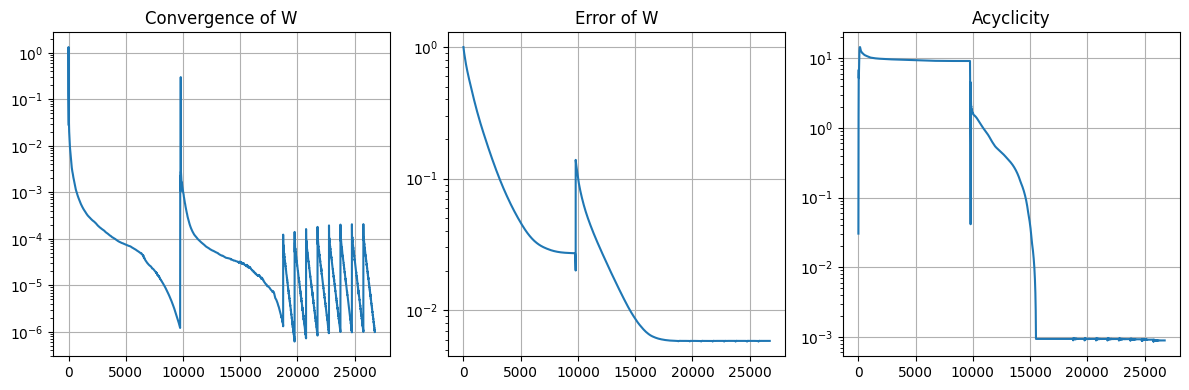

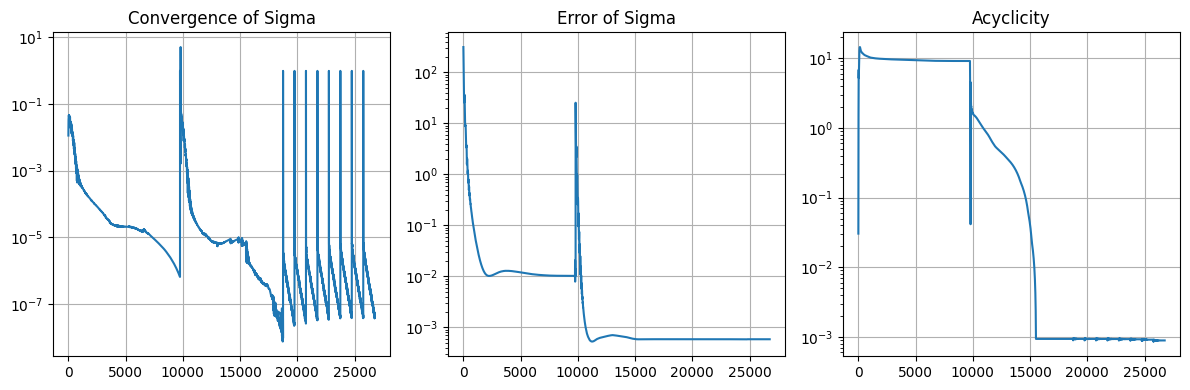

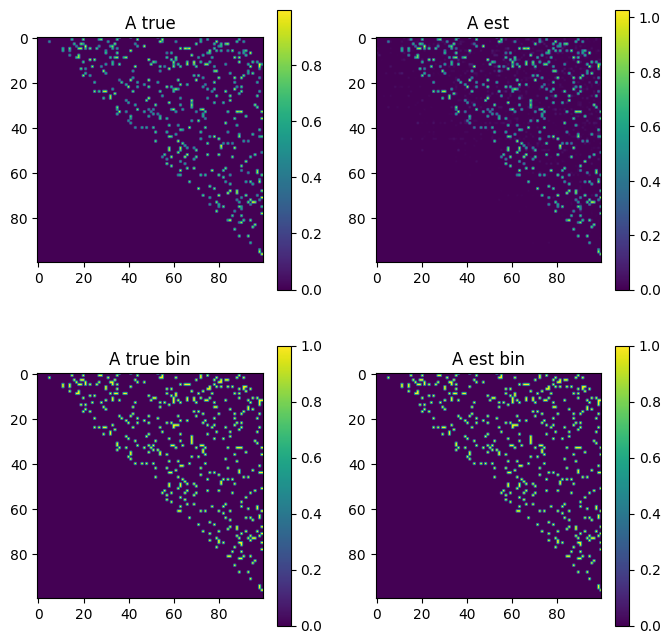

In [ ]:
lamb = get_lamb_value(N, M, .1)
args = {'stepsize': 3e-4, 'alpha_0': .01, 'rho_0': .05, 's': 1, 'lamb': lamb, 'iters_in': 30000,
            'iters_out': 10, 'tol': 1e-6, 'beta': 2, 'sca_adam': True, 'verb': True}
# args = {'stepsize': 5e-3, 'alpha': .5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}

print('lamb:', lamb)

t_i = time.time()
model = MetMulColide(acyclicity='logdet', primal_opt='sca', restart=True)
A_est, Sigma_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
plot_convergence(model, A, var_name="W")
plot_convergence(model, Sigma, var_name="Sigma")
plot_result(A, A_est, thr)

# Algorithms with Matrix Exponential Acyclicity

## Projected Gradient Descent Algorithms

### Standard PGD

lamb: 1.3572280848830223e-05


Solved in 38.714086 seconds
Mean est value: 0.011159814199289799
Err: 1.363  -  Err bin: 1.766  -  shd: 417  -  fscore: 0.041


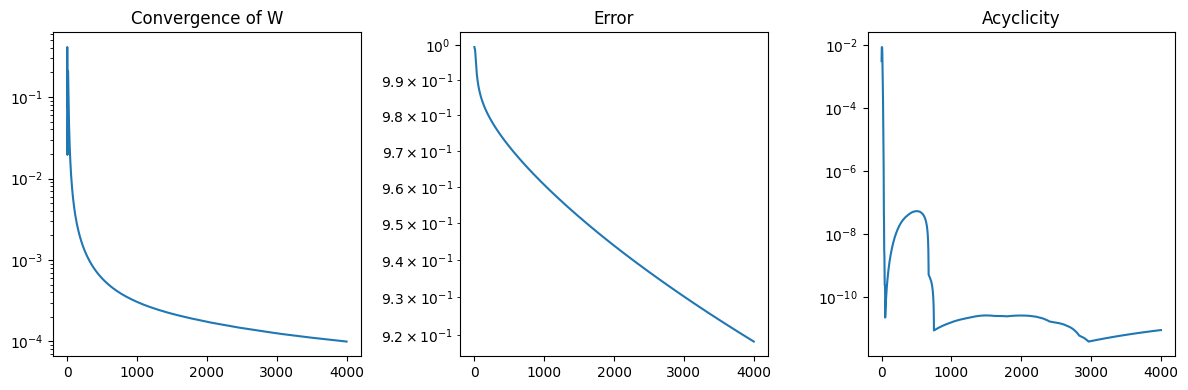

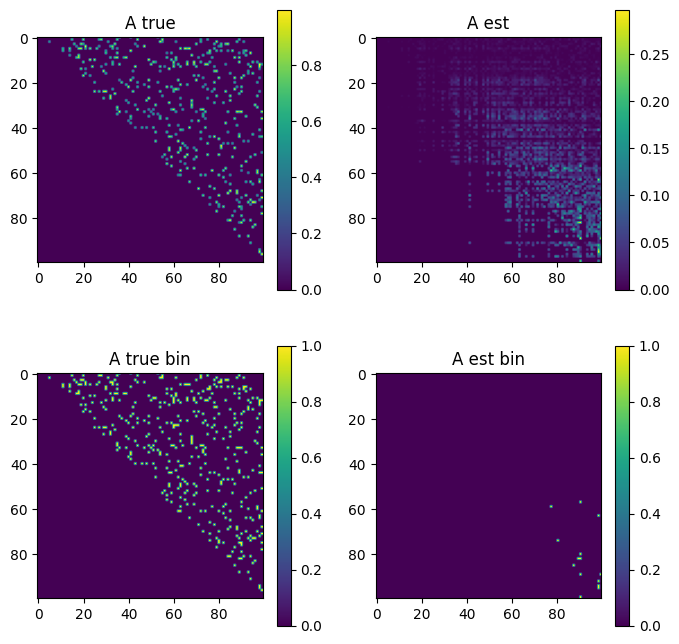

In [ ]:
# lamb = get_lamb_value(N, M, 2e-4)
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-6, 'alpha': 1e5, 'lamb': lamb, 'max_iters': 70000, 'tol': 1e-4}

print('lamb:', args['lamb'])

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='matexp', primal_opt='pgd')
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True, verb=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### FISTA

In [ ]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-6, 'alpha': 1e5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-5}

t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='matexp', primal_opt='fista')
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True, verb=True)
t_solved = time.time() - t_i
print(f'Accelerated: Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

### Proj Adam

Adam: Solved in 102.863317 seconds
Mean est value: 0.018220958417244738
Err: 1.435  -  Err bin: 1.000  -  shd: 380  -  fscore: 0.000


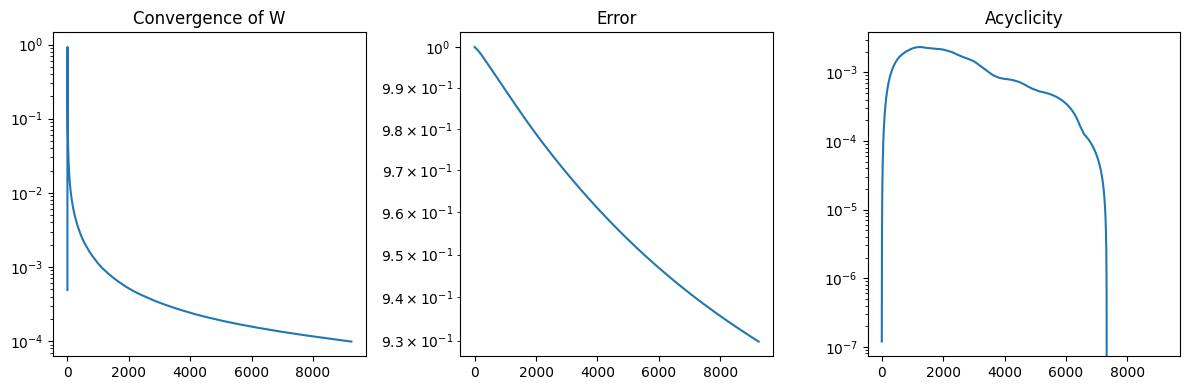

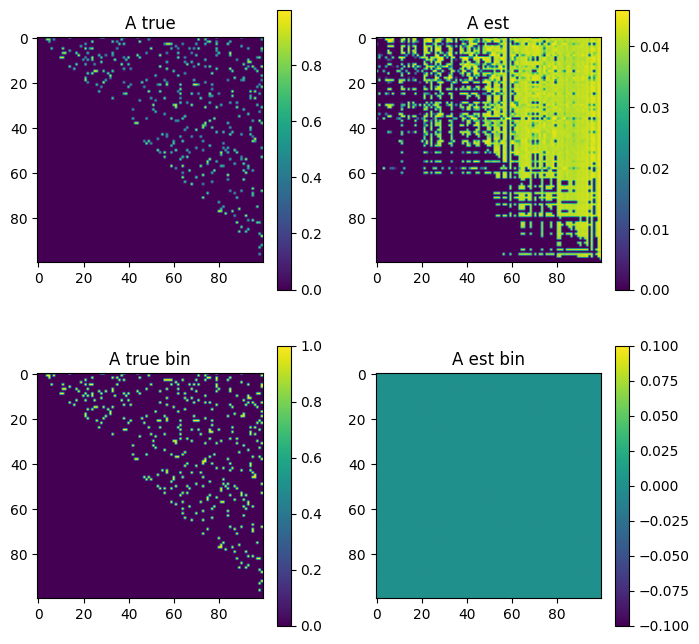

In [ ]:
lamb = get_lamb_value(N, M, 2e-4)
args = {'stepsize': 5e-6, 'alpha': 1e5, 's': 1, 'lamb': lamb, 'max_iters': 20000, 'tol': 1e-4}
# args = {'stepsize': 1e-6, 'alpha': 1e6, 'lamb': .05, 'max_iters': 1000, 'tol': 1e-6, 'checkpoint': 50}
t_i = time.time()
model_ppgd = Nonneg_dagma(acyclicity='matexp', primal_opt='adam')
A_dagma2 = model_ppgd.fit(X, **args, track_seq=True, verb=True)
t_solved = time.time() - t_i
print(f'Adam: Solved in {t_solved:3f} seconds')


# Plot description
thr = .2
print('Mean est value:', A_dagma2.mean())
plot_convergence(model_ppgd, A)
plot_result(A, A_dagma2, thr)

## Method of Multipliers Algorithms

### Standard MM

lamb: 0.006786140424415112


- 1/5. Diff: 0.000052 | Acycl: 0.193856 | Rho: 50.000 - Alpha: 19.693 - Step: 0.0001
- 2/5. Diff: 0.000023 | Acycl: 0.039095 | Rho: 50.000 - Alpha: 21.648 - Step: 0.0001
- 3/5. Diff: 0.000013 | Acycl: 0.022197 | Rho: 250.000 - Alpha: 27.197 - Step: 0.0001
- 4/5. Diff: 0.000009 | Acycl: 0.012713 | Rho: 1250.000 - Alpha: 43.088 - Step: 0.0001
- 5/5. Diff: 0.000007 | Acycl: 0.008348 | Rho: 6250.000 - Alpha: 95.263 - Step: 0.0001
Solved in 791.240308 seconds
Mean est value: 0.024095628234365462
Err: 0.226  -  Err bin: 0.243  -  shd: 84  -  fscore: 0.879


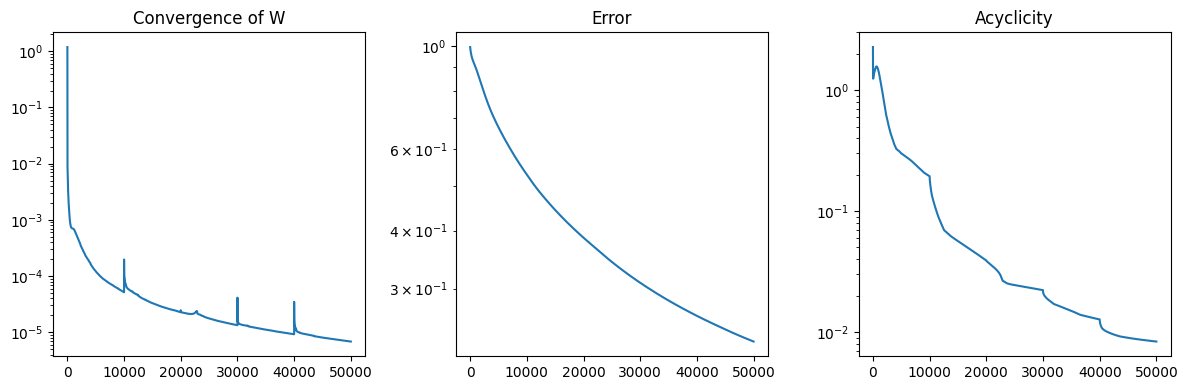

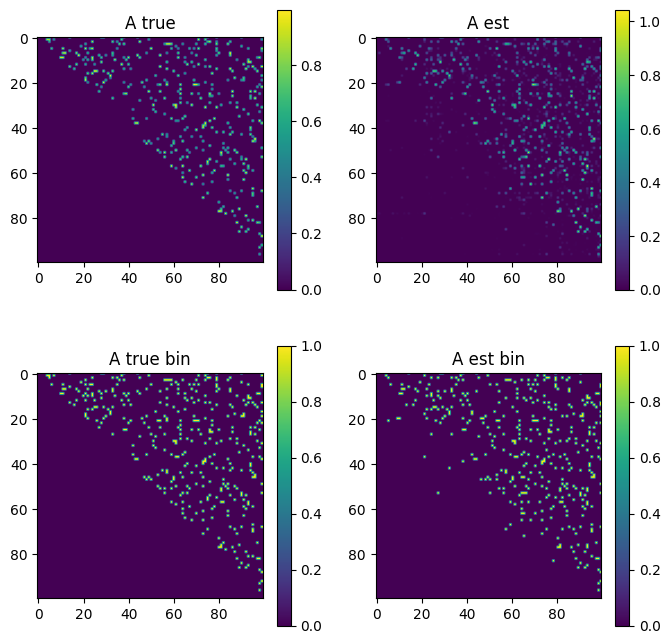

In [ ]:
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 1e-4, 'alpha_0': 10, 'rho_0': 10, 's': 1, 'lamb': .05, 'iters_in': 10000,
            'iters_out': 5, 'tol': 1e-6, 'beta': 5, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='matexp', primal_opt='pgd')
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

### MM + Fista

lamb: 0.006786140424415112


- 1/5. Diff: 0.000088 | Acycl: 0.134975 | Rho: 100.000 - Alpha: 14.497 - Step: 0.0000
- 2/5. Diff: 0.000034 | Acycl: 0.134247 | Rho: 1000.000 - Alpha: 148.745 - Step: 0.0000
- 3/5. Diff: 0.000091 | Acycl: 0.002511 | Rho: 1000.000 - Alpha: 151.256 - Step: 0.0000
- 4/5. Diff: 0.000002 | Acycl: 0.002510 | Rho: 10000.000 - Alpha: 176.360 - Step: 0.0000
- 5/5. Diff: 0.000003 | Acycl: 0.002508 | Rho: 100000.000 - Alpha: 427.204 - Step: 0.0000
Solved in 73.724782 seconds
Mean est value: 0.024998767301775932
Err: 0.094  -  Err bin: 0.120  -  shd: 36  -  fscore: 0.940


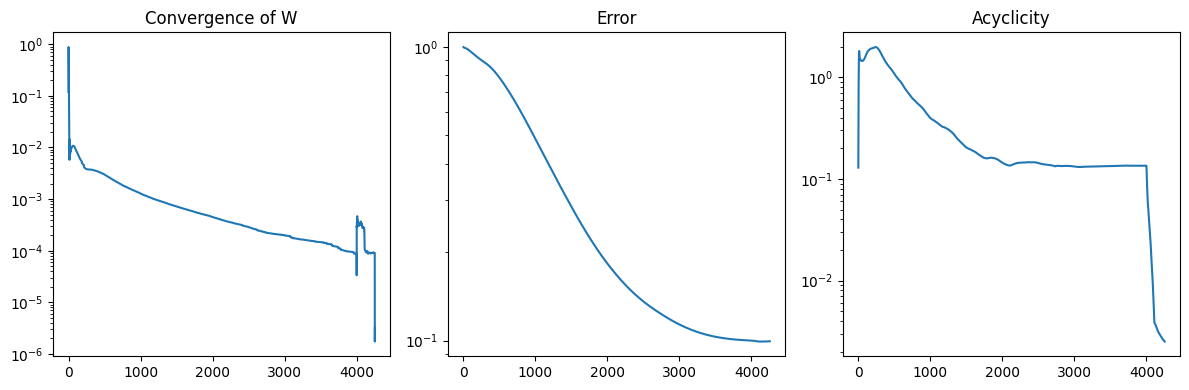

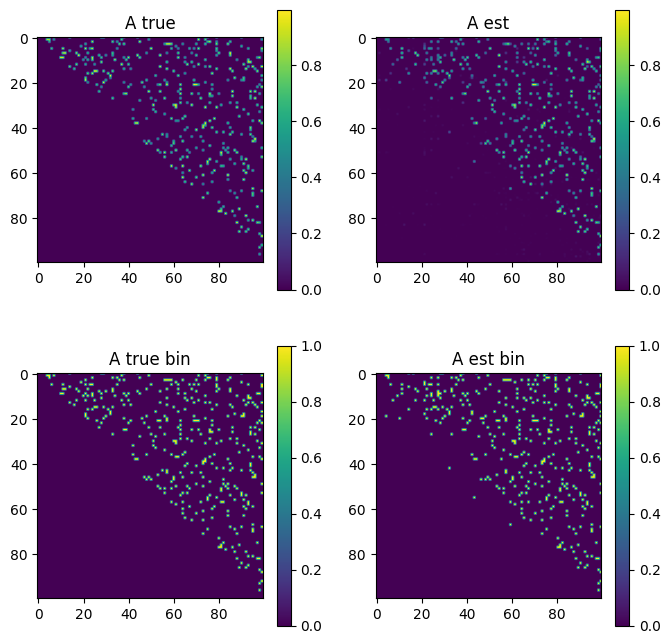

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 1e-1)

args = {'stepsize': 1e-5, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .05, 'iters_in': 10000,
            'iters_out': 5, 'tol': 1e-4, 'beta': 10, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='matexp', primal_opt='fista')
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

### MM + Adam

lamb: 0.006786140424415112


- 1/5. Diff: 0.000127 | Acycl: 0.401569 | Rho: 100.000 - Alpha: 41.157 - Step: 0.0001
- 2/5. Diff: 0.000032 | Acycl: 0.003253 | Rho: 100.000 - Alpha: 41.482 - Step: 0.0001
- 3/5. Diff: 0.000008 | Acycl: 0.003490 | Rho: 1000.000 - Alpha: 44.972 - Step: 0.0001
- 4/5. Diff: 0.000005 | Acycl: 0.003151 | Rho: 10000.000 - Alpha: 76.480 - Step: 0.0001
- 5/5. Diff: 0.000009 | Acycl: 0.001254 | Rho: 100000.000 - Alpha: 201.830 - Step: 0.0001
Solved in 273.089011 seconds
Mean est value: 0.02593373541378939
Err: 0.138  -  Err bin: 0.203  -  shd: 68  -  fscore: 0.898


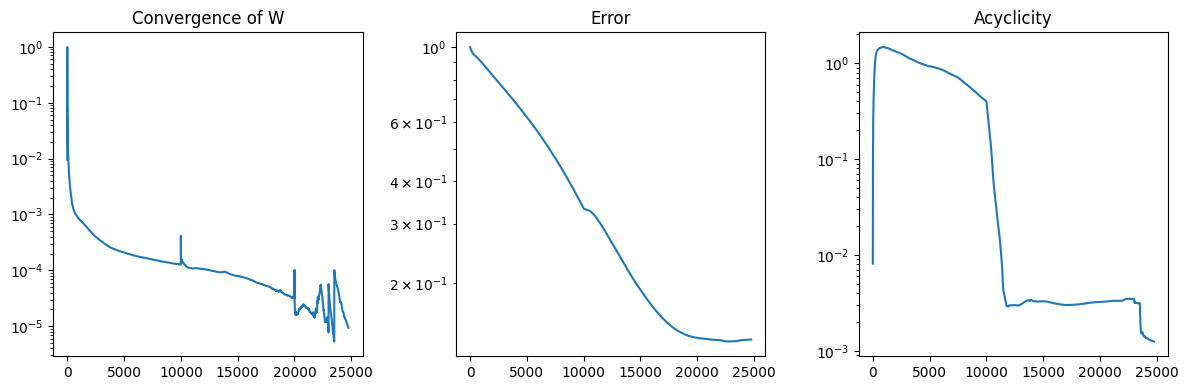

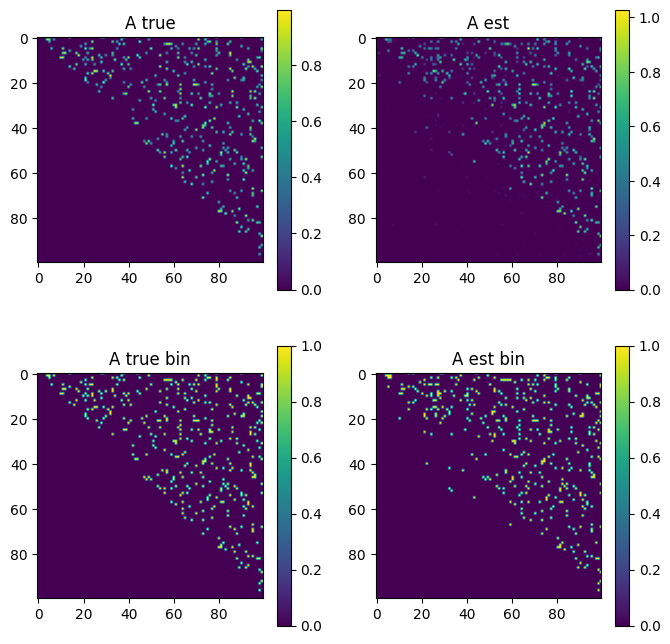

In [ ]:
## Second set of hyperparams N = 50
lamb = get_lamb_value(N, M, 1e-1)
args = {'stepsize': 1e-4, 'alpha_0': 1, 'rho_0': 10, 's': 1, 'lamb': .05, 'iters_in': 10000,
            'iters_out': 5, 'tol': 1e-5, 'beta': 10, 'verb': True}

print('lamb:', lamb)

t_i = time.time()
model = MetMulDagma(acyclicity='matexp', primal_opt='adam')
A_est = model.fit(X, **args, track_seq=True)
t_solved = time.time() - t_i
print(f'Solved in {t_solved:3f} seconds')

# Plot description
thr = .2
print('Mean est value:', A_est.mean())
plot_convergence(model, A, var_name="W")
plot_result(A, A_est, thr)

### Logarithmic barrier DAGMA Alg

In [ ]:
# ## Second set of hyperparams N = 50

# lamb = get_lamb_value(N, M, 2e-2)
# print('lamb:', lamb)
# if norm_x:
#     lamb = get_lamb_value(N, M, 2e-4)
#     args = {'stepsize': 5e-1, 'alpha': 5e-3, 's': 1, 'lamb': lamb, 'iters_in': 5000,
#             'iters_out': 10, 'tol': 1e-6, 'beta': .5, 'verb': True}
# else:
#     lamb = get_lamb_value(N, M, 2e-2)
#     args = {'stepsize': 2e-2, 'alpha': .01, 's': 1, 'lamb': lamb, 'iters_in': 100,
#             'iters_out': 100, 'tol': 1e-6, 'beta': .9, 'verb': True}


# t_i = time.time()
# model = BarrierDagma()
# A_est = model.fit(X, **args, track_seq=True)
# t_solved = time.time() - t_i
# print(f'Solved in {t_solved:3f} seconds')

# # Plot description
# thr = .2
# plot_convergence(model, A, var_name="W")
# plot_result(A, A_est, thr)